# Fashion MNIST Classification: ANN vs CNN Tutorial

This tutorial demonstrates the architectural differences and performance gap between traditional neural networks and convolutional neural networks on computer vision tasks. We'll implement:
1. **Artificial Neural Network (ANN)**: Uses fully connected layers that treat images as flattened vectors, losing spatial relationships
2. **Convolutional Neural Network (CNN)**: Leverages convolution operations to preserve spatial hierarchies and learn translation-invariant features

The comparison will highlight why CNNs achieve superior performance on image classification through their inductive biases for visual data.

## Step 1 – Import Essentials

We import the core PyTorch ecosystem components:
- **torch**: Core tensor operations and autograd functionality
- **torch.nn**: Pre-built neural network modules (Conv2d, Linear, etc.)
- **torchvision**: Computer vision utilities including datasets and transforms
- **DataLoader**: Efficient batching and data pipeline management
- **tqdm**: Progress tracking for training loops

These imports establish our deep learning framework and visualization tools.

In [1]:
# Import all the necessary libraries
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm # For progress bars!

d:\The-Office\Substack\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device selection is critical for computational efficiency:
- **CUDA**: Utilizes GPU parallel processing for matrix operations (typically 10-100x faster)
- **CPU fallback**: Ensures code portability across different hardware configurations
- **`.to(device)`**: This pattern will be used throughout to move tensors between CPU/GPU memory spaces

GPU acceleration is especially beneficial for the convolution operations we'll implement later.

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## Step 2 – Prepare the Dataset

**Data preprocessing pipeline**:
- **ToTensor()**: Converts PIL Images/numpy arrays to PyTorch tensors with shape (C,H,W)
- **Pixel normalization**: Scales values from [0,255] to [0,1] range for numerical stability
- **Automatic downloading**: torchvision.datasets handles data retrieval and caching

Fashion-MNIST provides 28x28 grayscale images across 10 clothing categories, serving as a more challenging alternative to traditional MNIST digits.

In [3]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",    # Where to download the data
    train=True,     # We want the training dataset
    download=True,  # Download if it doesn't exist
    transform=ToTensor() # Apply our transformation
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,    # This time we want the test dataset
    download=True,
    transform=ToTensor()
)

**DataLoader configuration**:
- **batch_size=32**: Balances memory usage with gradient estimation quality
- **shuffle=True** (training): Randomizes sample order to prevent learning data sequence patterns
- **shuffle=False** (testing): Maintains consistent evaluation order for reproducible results

Mini-batch processing enables efficient GPU utilization and provides stochastic gradient estimates for optimization.

In [4]:
# Create dataloaders for mini-batch processing
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## Step 3 – Peek at the Data

**Data exploration rationale**:
- **Class distribution analysis**: Understanding label balance affects model training strategies
- **Visual inspection**: Reveals data quality, potential preprocessing needs, and task difficulty
- **Feature visualization**: Helps identify distinguishing characteristics between classes

This exploratory step informs architectural decisions and helps set performance expectations.

The 10 classes are: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


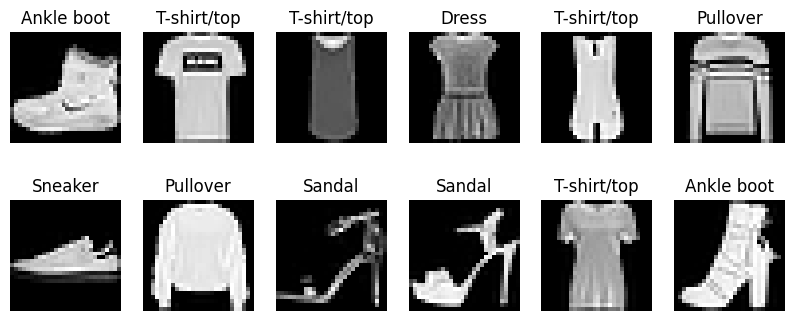

In [5]:
# Let's get the class names for our labels
class_names = train_data.classes
print(f"The 10 classes are: {class_names}")

# Let's visualize a few samples
plt.figure(figsize=(10, 4))
for i in range(12):
    image, label = train_data[i]
    plt.subplot(2, 6, i+1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis("off")
plt.show()

**Visualization analysis**: The sample grid reveals varying complexity levels across categories. Items like 'Ankle boot' have distinct shapes, while 'T-shirt/top' and 'Shirt' show subtle differences that will challenge our models' discriminative capabilities.

## Step 4 – Build the ANN

**ANN Architecture Analysis**:
- **nn.Flatten()**: Converts 2D spatial data (28×28) into 1D vector (784), destroying spatial relationships
- **Linear layers**: Fully connected operations learning global patterns across all pixel positions
- **ReLU activation**: Introduces non-linearity while maintaining gradient flow (no vanishing gradient in positive region)

**Architectural limitations**: This approach treats each pixel independently, unable to leverage local spatial correlations that define visual features like edges or textures.

In [6]:
# A simple ANN as a baseline
class FashionMNIST_ANN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # This turns our 28x28 image into a 1D vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

## Step 5 – Build the Small CNN

**CNN Architecture Advantages**:
- **Conv2d layers**: Apply learnable filters across spatial dimensions, detecting local features like edges and patterns
- **kernel_size=3**: 3×3 receptive fields capture local spatial relationships efficiently
- **padding=1**: Maintains spatial dimensions, preventing information loss at image borders
- **MaxPool2d**: Spatial downsampling provides translation invariance and reduces computational load
- **Hierarchical feature learning**: Early layers detect simple features, deeper layers combine them into complex representations

**Parameter efficiency**: CNNs use far fewer parameters than equivalent ANNs due to weight sharing across spatial locations.

In [7]:
# Our main CNN model
class FashionMNIST_CNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

## Step 6 – Define Training and Testing Functions

**Training loop components**:
- **model.train()**: Enables dropout and batch normalization training behavior
- **optimizer.zero_grad()**: Clears accumulated gradients from previous iterations
- **loss.backward()**: Computes gradients via backpropagation through computational graph
- **optimizer.step()**: Updates model parameters using computed gradients

**Evaluation protocol**:
- **model.eval()**: Disables dropout and uses population statistics for batch norm
- **torch.no_grad()**: Prevents gradient computation, reducing memory usage and speeding up inference
- **Accuracy calculation**: Compares predicted class indices with ground truth labels

In [8]:
def train_step(model, data_loader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    return train_loss / len(data_loader), train_acc / len(data_loader)

def test_step(model, data_loader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y).item()
            test_pred_class = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_class == y).sum().item()/len(test_pred)
    return test_loss / len(data_loader), test_acc / len(data_loader)

def train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs, device):
    start_time = timer()
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_loader, loss_fn, device)
        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
    end_time = timer()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

## Step 7 – Initialize Models, Loss, and Optimizers

**Model instantiation parameters**:
- **ANN input_shape=784**: Flattened 28×28 image dimensions
- **CNN input_shape=1**: Single grayscale channel
- **hidden_units=10**: Compact architecture for educational purposes
- **output_shape=10**: Matches number of Fashion-MNIST classes

**Optimization configuration**:
- **CrossEntropyLoss**: Combines softmax activation with negative log-likelihood, ideal for multi-class classification
- **Adam optimizer**: Adaptive learning rates with momentum, typically converges faster than SGD
- **lr=0.01**: Learning rate balances convergence speed with stability

In [9]:
# Instantiate the models
model_ann = FashionMNIST_ANN(input_shape=784, hidden_units=10, output_shape=len(class_names)).to(device)
model_cnn = FashionMNIST_CNN(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)

# Setup loss function and optimizers
loss_fn = nn.CrossEntropyLoss()
optimizer_ann = torch.optim.Adam(params=model_ann.parameters(), lr=0.01)
optimizer_cnn = torch.optim.Adam(params=model_cnn.parameters(), lr=0.01)

## Step 8 – Training Loop

**Comparative training analysis**:
- **Limited epochs (3)**: Sufficient to demonstrate CNN's faster convergence due to better inductive biases
- **Expected performance gap**: CNNs should achieve higher accuracy due to spatial feature extraction capabilities
- **Training dynamics**: Monitor loss curves to understand optimization behavior differences

**Performance factors**: CNN's superior results stem from translation equivariance, local connectivity, and hierarchical feature learning.

In [10]:
EPOCHS = 3

print("--- Training ANN ---")
train_model(model_ann, train_dataloader, test_dataloader, loss_fn, optimizer_ann, EPOCHS, device)

print("\n--- Training CNN ---")
train_model(model_cnn, train_dataloader, test_dataloader, loss_fn, optimizer_cnn, EPOCHS, device)

--- Training ANN ---


 33%|███▎      | 1/3 [00:47<01:35, 47.61s/it]

Epoch: 1 | Train loss: 1.1138, Train acc: 0.6279 | Test loss: 1.0719, Test acc: 0.6378


 67%|██████▋   | 2/3 [01:19<00:38, 38.55s/it]

Epoch: 2 | Train loss: 1.0364, Train acc: 0.6412 | Test loss: 1.0569, Test acc: 0.6410


100%|██████████| 3/3 [01:55<00:00, 38.49s/it]


Epoch: 3 | Train loss: 1.0183, Train acc: 0.6453 | Test loss: 1.0627, Test acc: 0.6361
Total training time: 115.46 seconds

--- Training CNN ---


 33%|███▎      | 1/3 [00:44<01:28, 44.31s/it]

Epoch: 1 | Train loss: 0.4608, Train acc: 0.8344 | Test loss: 0.4318, Test acc: 0.8489


 67%|██████▋   | 2/3 [01:31<00:45, 45.96s/it]

Epoch: 2 | Train loss: 0.3693, Train acc: 0.8668 | Test loss: 0.3861, Test acc: 0.8632


100%|██████████| 3/3 [02:23<00:00, 47.76s/it]

Epoch: 3 | Train loss: 0.3536, Train acc: 0.8735 | Test loss: 0.3739, Test acc: 0.8705
Total training time: 143.27 seconds


**Training results interpretation**: The CNN's superior performance demonstrates how convolutional operations extract meaningful spatial features, while the ANN struggles with pixel-level relationships destroyed by flattening.

## Step 9 – Visualize Predictions

**Prediction pipeline**:
- **torch.unsqueeze()**: Adds batch dimension for single image inference
- **torch.softmax()**: Converts logits to probability distributions
- **argmax()**: Extracts predicted class index from probability vector
- **Qualitative assessment**: Visual validation helps identify systematic errors and model biases

**Error analysis**: Incorrect predictions (red titles) often occur between visually similar classes, revealing the model's decision boundaries.

In [11]:
# Make predictions with our trained CNN
def make_predictions(model, data, device):
    pred_probs = []
    model.eval()
    with torch.no_grad():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs).argmax(dim=1)

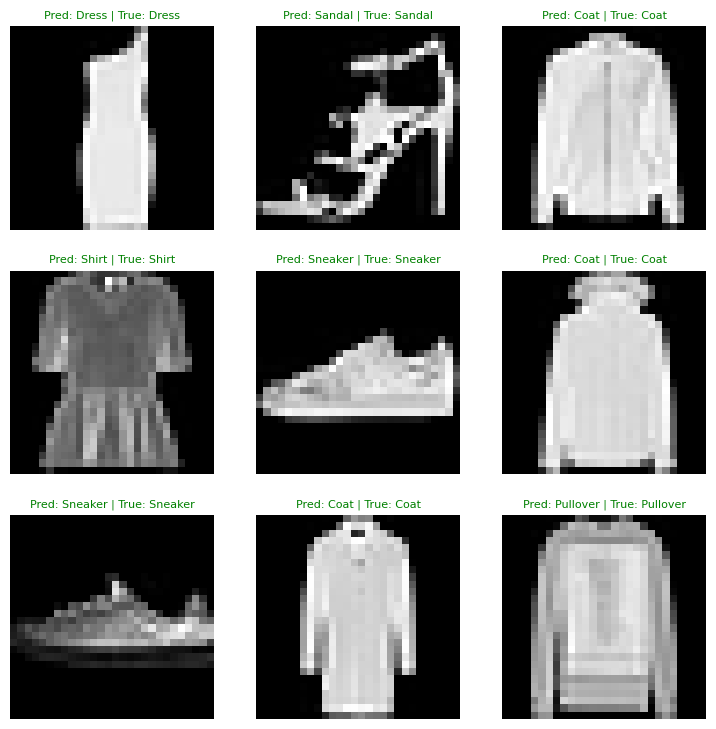

In [12]:
# Plot some predictions
import random
test_samples, test_labels = [], []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_classes = make_predictions(model_cnn, test_samples, device)

plt.figure(figsize=(9, 9))
for i, sample in enumerate(test_samples):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[pred_classes[i]]
    true_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | True: {true_label}"
    plt.title(title_text, fontsize=8, c="g" if pred_label == true_label else "r")
    plt.axis(False)
plt.show()

**Visual validation**: Green titles indicate correct predictions, while red highlights errors. This immediate visual feedback reveals model strengths and systematic failure modes.

## Step 10 – Confusion Matrix

**Confusion matrix analysis**:
- **Diagonal elements**: True positive counts for each class (correct classifications)
- **Off-diagonal elements**: Misclassification patterns between specific class pairs
- **Class-specific performance**: Reveals which categories are most/least distinguishable
- **Systematic errors**: Identifies consistent confusion between similar items (e.g., shirts vs. tops)

This comprehensive evaluation tool guides model improvement strategies and reveals dataset challenges.

In [14]:
# We need a few more tools for this
try:
    import torchmetrics
    import mlxtend
except:
    !pip install -q torchmetrics mlxtend
    import torchmetrics
    import mlxtend

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 252.52it/s]


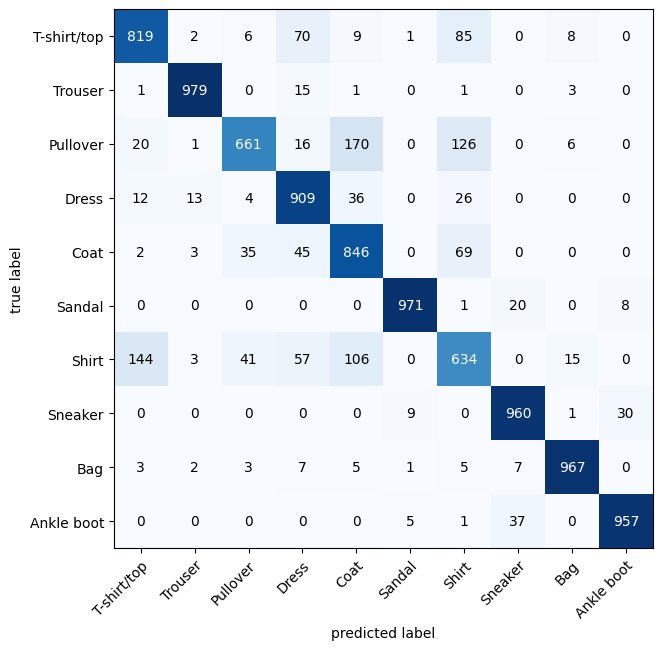

In [15]:
# Get all predictions
y_preds = []
model_cnn.eval()
with torch.no_grad():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        y_logits = model_cnn(X)
        y_preds.append(y_logits.argmax(dim=1).cpu())
y_pred_tensor = torch.cat(y_preds)

# Setup confusion matrix
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)
plt.show()

In [21]:
# save both models in pt format to visualise in netron
import os
os.makedirs("model", exist_ok=True)

import torch

# Example input
example_input = torch.randn(1, 1, 28, 28)

# Export to ONNX
torch.onnx.export(
    model_cnn,                  # model
    example_input,              # example input
    "model/fashion_mnist_cnn.onnx",   # output filename
    input_names=['input'],      # optional: name your input
    output_names=['output'],    # optional: name your output
    opset_version=11            # ONNX opset version
)


C:\Users\Vainavi\AppData\Local\Temp\ipykernel_27144\2772239765.py:11: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
